# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

# Introduction

The main goal of this project is to predict which recipes wil be popular 80% of the time and minimize the chance of showing unpopular recipes on the companies homepage, for the project team.

# Data Validation

In [6]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import auc, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer

# use ggplot style
plt.style.use('ggplot')
# set style to colorblind with max of 3 colors
sns.set_palette(sns.color_palette("colorblind", 2))

# show all columns, more rows in df
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 100)

In [7]:
# read in csv file
recipes = pd.read_csv('../data/recipe_site_traffic_2212.csv')

# look at first few lines of df
recipes.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [8]:
# look at df shape
recipes.shape

(947, 8)

In [9]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [10]:
# check for missing values
recipes.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [11]:
# check for duplicate values
recipes.duplicated().sum()

0

In [12]:
# check data types
recipes.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

In [13]:
# stats for numeric variables
recipes.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


In [14]:
# stats for object variables
recipes.describe(include=['object'])

,category,servings,high_traffic
count,947,947,574
unique,11,6,1
top,Breakfast,4,High
freq,106,389,574


## Initial Data Cleaning

In [16]:
# reset initial index
recipes.reset_index(drop=True, inplace=True)

# set index to recipe
recipes.set_index('recipe', inplace=True)

print(recipes.index)

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       938, 939, 940, 941, 942, 943, 944, 945, 946, 947],
      dtype='int64', name='recipe', length=947)


In [17]:
# display counts of the different categories 
print(recipes['category'].value_counts(dropna=False))

# convert to categorical type
recipes['category'] = recipes['category'].astype('category')

print(recipes['category'].dtype)

category
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: count, dtype: int64
category


In [18]:
# analyze the 'servings' variable
recipes['servings'].value_counts(dropna=False)

# convert 'servings' column to string type, then to numeric by extracting the first number
recipes['servings'] = recipes['servings'].astype(str).str.extract('(\d+)').astype(int)

# this feature appears to be best suited to be an ordered categorical variable, so will change the datatype

# define the order of the categories
servings_order = [1, 2, 4, 6]

# convert to ordered categorical variable
recipes['servings'] = pd.Categorical(recipes['servings'], categories=servings_order, ordered=True)

# verify datatype
print(recipes['servings'].dtype)


category


In [19]:
# fill missing high_traffic values
# for the target variable, Nan actually represents the values that are not 'High'.  

# fill na values (not high traffic) with 0
recipes['high_traffic'].fillna(0, inplace=True)

# change high_traffic to 1
recipes.loc[recipes['high_traffic'] == 'High', 'high_traffic'] = 1

# convert to binary (integer)
recipes['high_traffic'] = recipes['high_traffic'].astype('int')

print(recipes['high_traffic'].value_counts())


high_traffic
1    574
0    373
Name: count, dtype: int64


In [20]:
# fill missing values in 'protein', 'sugar', 'carbohydrate', and 'calories' with the median value of their respective category.
for column in ['protein', 'sugar', 'carbohydrate', 'calories']:
    recipes[column] = recipes.groupby('category')[column].transform(lambda x: x.fillna(x.median()))


C:\Users\trobb\AppData\Local\Temp\ipykernel_9772\558041826.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recipes[column] = recipes.groupby('category')[column].transform(lambda x: x.fillna(x.median()))


In [21]:
# recheck for missing values
recipes.isna().sum()

calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

In [22]:
# check adjusted datatypes
recipes.dtypes

calories         float64
carbohydrate     float64
sugar            float64
protein          float64
category        category
servings        category
high_traffic       int32
dtype: object

The dataset contains 947 rows and 8 columns:

- **recipe**: This numeric (int64) variable serves as the unique identifier for each recipe, as specified in the data dictionary. The values are consecutive, ranging from 1 to 947, with no duplicates or missing values. Recipe has been set as the index of the dataframe.  No additional cleaning is required.

- **calories**: A numeric (float64) variable that represents the number of calories, as stated in the data dictionary. This column had 52 missing values, which were imputed using the median of the calories group, as the median is more robust to outliers than the mean. The calorie count ranges from 0.14 to 3,633.16. The significant difference between the mean (435.94) and the median (288.55) could indicate the presence of outliers. During the model preprocessing phase, this variable was transformed using a log-transformation and scaled using RobustScaler, which works good against outliers.

- **carbohydrate**: This numeric (float64) variable represents the amount of carbohydrates in grams, as detailed in the data dictionary. There were 52 missing values, which were filled through median imputation. The carbohydrate content ranges from 0.03 grams to 530.42 grams. The mean (35.07) and median (21.48) values differ significantly, possibly indicating outliers. During the model preprocessing phase, this variable was transformed using a log-transformation and scaled using RobustScaler.

- **sugar**: A numeric (float64) variable that indicates the amount of sugar in grams. This column had 52 missing values, which were addressed by median imputation. The sugar content ranges from 0.01 to 148.75. The mean (9.05) and median (4.55) values also vary, suggesting the possibility of outliers. During the preprocessing phase, this variable was transformed using a log-transformation and scaled using RobustScaler.

- **protein**: There were 52 missing values, filled using median imputation. This numeric (float64) variable represents the protein content in grams. The range is from 0.0 to 363.36, with a mean of 24.15 and a median of 10.8. This variance could also hint at potential outliers. During the preprocessing phase, this variable was transformed using a log-transformation and scaled using RobustScaler

- **category**: This variable is a character/object type, as indicated in the data dictionary, and contains 11 unique values (Breakfast, Chicken Breast, Beverages, Lunch/Snacks, Potato, Pork, Vegetable, Dessert, Meat, Chicken, One Dish Meal), one more than the 10 listed in the data dictionary, as chicken breast was initially left out. It has been converted to a categorical data type to enhance data processing efficiency and enable more intuitive analysis, as it represents the food category for each recipe. There is no hierarchical order among the categories, and there are no missing values. During the model preprocessing phase, one-hot coding was applied to category to convert to numeric variables, as the models only accept numerical input.

- **servings**: This variable, of the character/object data type in Python, represents the number of servings for each recipe, not 100% numeric as stated in the data dictionary. It includes six different values: 1, 2, 4, 6, '4 as a snack', and '6 as a snack'. The 'as a snack' values were standardized by extracting the first character, and then converting them to an ordered categorical format. This approach will preserve the inherent categorical nature of the data and ensure better compatibility with various analytical models. There are no missing values. Similar to 'category', one-hot coding was applied to handle the categorical encoding during the model reprocessing phase.

- **high_traffic**: This character/object variable, as mentioned in the data dictionary, marks recipes with "High" if they experienced high traffic. Recipes not marked are shown as NaN in the dataset. There are 574 recipes marked as "high" and 373 that are not. The term 'High' was changed to 1, and the NaN values were changed to 0 to prepare the date for modeling. After this modification, there are no missing values.


# Exploratory Analysis

## Target Variable - high_traffic

C:\Users\trobb\AppData\Local\Temp\ipykernel_9772\3203155621.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])


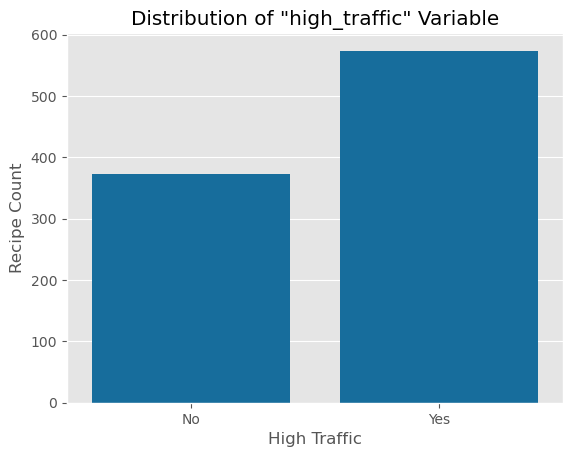

In [26]:
# countplot of high_traffic (target) variable
fig, ax = plt.subplots()

sns.countplot(x='high_traffic', data=recipes)
ax.set(title='Distribution of "high_traffic" Variable', xlabel='High Traffic', ylabel='Recipe Count')
ax.set_xticklabels(['No', 'Yes'])

plt.show()

The target variable has 574 recipes that are rated high (marked as 1) and 373 not rated high (marked as 0), which appears to be a slight imbalance. In an unbalanced dataset, there is a "highly unequal" (such as 900 to  100) distribution of classes in the target column. However, I would consider the below a balanced dataset as there is an "approximately equal" distribution of the two classes.

## Numeric Variables

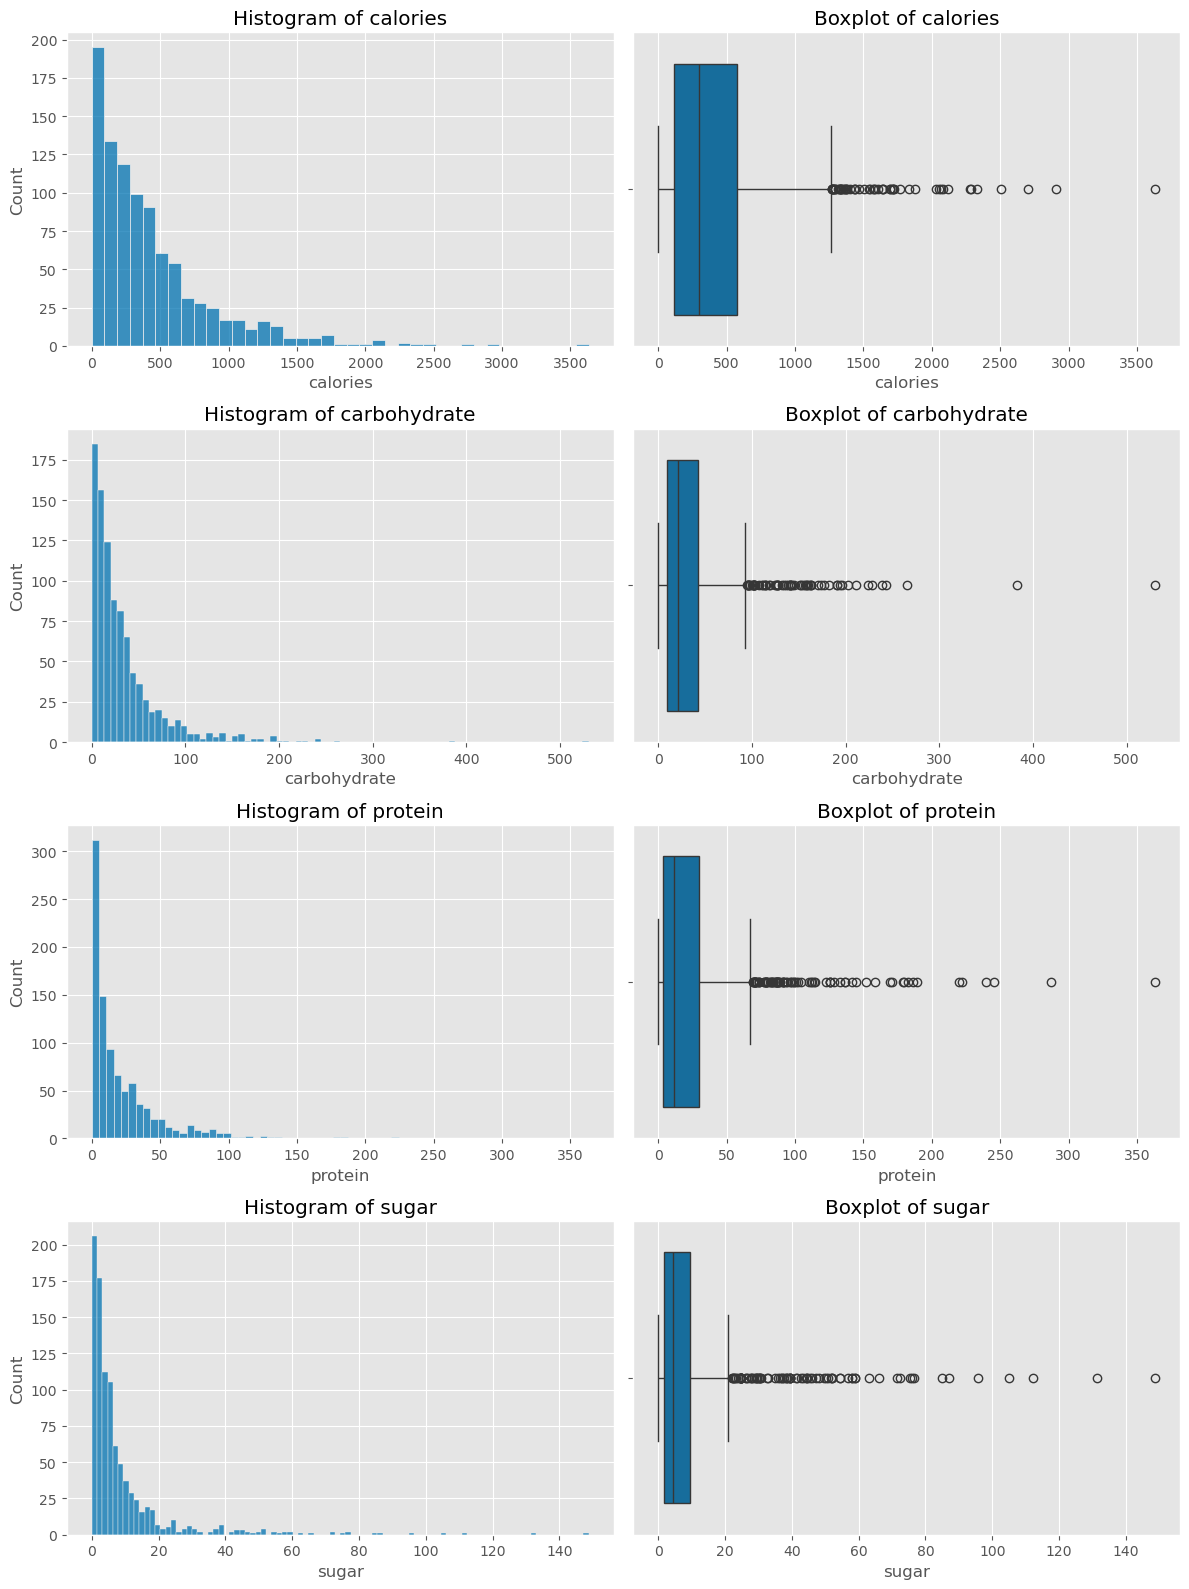

In [29]:
# select numeric columns for plotting
numeric_columns = ['calories', 'carbohydrate', 'protein', 'sugar']

# set number of rows based on number of numeric columns
num_rows = len(numeric_columns)

# create subplots, set figsize
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 4))

# loop through relevant numeric variables
for i, col in enumerate(numeric_columns):
    # plot histogram on the left
    sns.histplot(recipes[col], ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {col}')

    # plot boxplot on the right
    sns.boxplot(x=recipes[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')

# display plot
plt.tight_layout()
plt.show()

- Calories: The histogram appears to be right-skewed, indicating that most recipes have lower calorie counts, with fewer recipes having very high calorie values. The boxplot indicates the presence of outliers above the upper whisker, suggesting that some recipes have significantly higher calories than the rest.

- Carbohydrate: The histogram also seems right-skewed, similar to the one for calories, with most recipes featuring lower carbohydrate content. The boxplot similarly identifies outliers on the higher end, indicating some recipes with exceptionally high carbohydrate content.

- Protein: The histogram for protein is also right-skewed, implying that most recipes contain lower levels of protein. The boxplot reveals outliers, suggesting that some recipes are exceptionally high in protein.

- Sugar: This histogram exhibits a right-skewed distribution as well, indicating that most recipes contain lower amounts of sugar. The accompanying boxplot shows several outliers, suggesting some recipes have unusually high sugar content.


### Correlation Among Numeric Variables

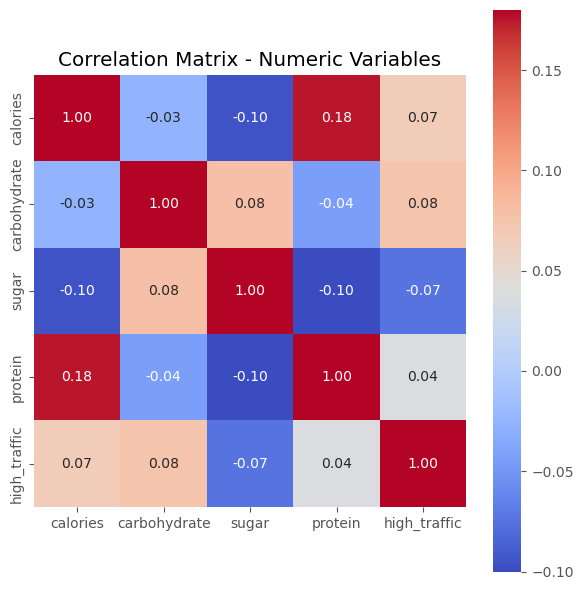

In [32]:
# select columns for heatmap
numeric = recipes[['calories', 'carbohydrate', 'sugar', 'protein', 'high_traffic']]

# determine correlation
num = numeric.corr()

# set figsize
fig, ax = plt.subplots(figsize=(6, 6))

# plot heatmap
sns.heatmap(num, annot=True, fmt='.2f', square=True, vmin=-0.10, vmax=0.18, cmap='coolwarm')
ax.set_title('Correlation Matrix - Numeric Variables')

# display plot
plt.tight_layout()
plt.show()

As can be seen in the correlation heatmap above, there appears to be very little correlation among the numeric variables:

- calories show a slightly positive correlation with protein (0.18), suggesting that as calorie content increases, protein content tends to increase as well, although weakly.
- The other variables show very weak to no correlation with each other and with high_traffic. The correlation coefficients are all close to zero, suggesting there is no strong linear relationship between these variables.


## Categorical Variables

C:\Users\trobb\AppData\Local\Temp\ipykernel_9772\382735112.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  traffic_counts = recipes.groupby('category')['high_traffic'].value_counts(normalize=True).unstack()


<Figure size 1400x1000 with 0 Axes>

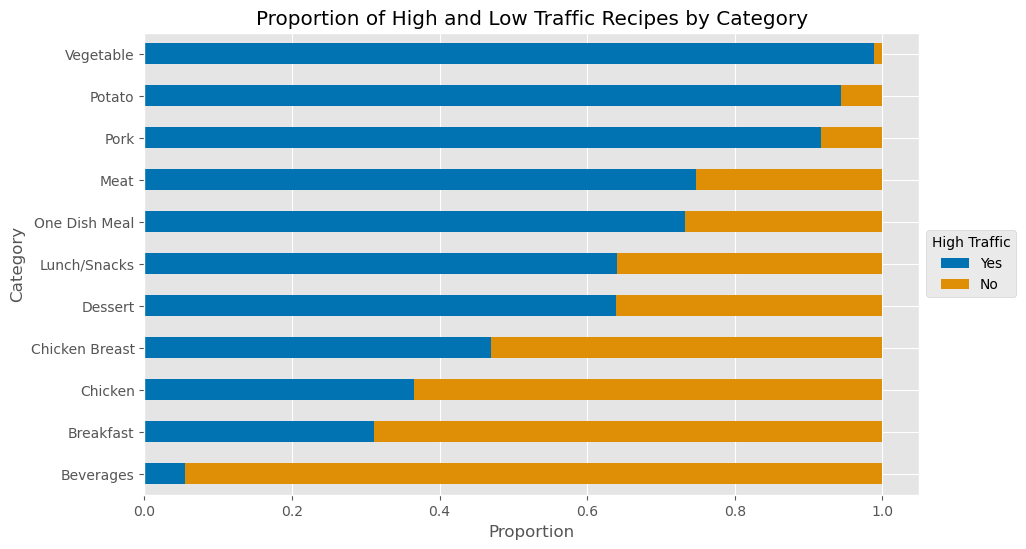

In [35]:
# count the number of high and low traffic recipes in each category
traffic_counts = recipes.groupby('category')['high_traffic'].value_counts(normalize=True).unstack()

# reverse the order of the columns for stacking and sorting by 'Yes' proportion
reversed_columns = traffic_counts.columns[::-1]
traffic_counts = traffic_counts[reversed_columns]

# sort by 'Yes' proportion
traffic_counts_sorted = traffic_counts.sort_values(by=1, ascending=False)

# define paette that is a colorblind-friendly
colors = sns.color_palette("colorblind")[:2]

# plot sorted horizontal stacked bar chart
plt.figure(figsize=(14, 10))
traffic_counts_sorted.plot(kind='barh', stacked=True, color=colors, figsize=(10, 6))
plt.xlabel('Proportion')
plt.ylabel('Category')
plt.title('Proportion of High and Low Traffic Recipes by Category')

plt.legend(title='High Traffic', labels=['Yes', 'No'], loc='center left', bbox_to_anchor=(1, 0.5))

# to display the highest 'Yes' proportion at the top
plt.gca().invert_yaxis() 
plt.show()

There is a noticeable variation in the proportions of high and low traffic recipes among different categories. Some categories, such as Vegetable, Potatoe, and Pork, have a significantly higher proportion of high traffic recipes, possibly indicating a stronger user interest or demand.

Categories with higher proportions of high traffic recipes might be given more prominence on the site, or the site could focus on adding more recipes in these popular categories. Conversely, categories with lower proportions of high traffic might be areas for investigation to understand why they are less popular and how they can be improved.

# Model **Development**

Since we're predicting one of two possible outcomes (high traffic or not) it's a binary classification problem.

I chose to use a random forest classifier as my baseline model, as they are inherently robust to outliers and make no assumptions about the data distribution.

The comparison model I am using is a gradient boosting machine (GBM) classifier, as it is also suitable for datasets where outliers are present and can handle complex, non-linear relationships which are common in skewed datasets.

For both models, it's important to note that while they have good native resilience to outliers and skewed data, best practices still recommend preprocessing steps such as outlier detection and removal, or transformations to reduce skewness, to potentially improve model performance. This will be handled during data preprocessing.

To initially evaluate the models, I will be using the F1 score. The F1 score is the harmonic mean of precision and recall and provides a single metric that balances the two. In our scenario, where both capturing as many high traffic recipes as possible (high recall) and maintaining the accuracy of the high traffic prediction (high precision) are important, I believe the F1 score is more appropriate than using recall or precision alone at this point in the project.

## Data Preprocessing

First, I divided the dataset into training and testing sets to assure an accurate evaluation of our models, while preventing any data leakage. Our dataset is made up of two categorical columns, 'category' and 'servings', alongside several numerical columns. For these numerical columns, I employed a log transformation to normalize their distribution, followed by scaling with a RobustScaler. This scaler is particularly effective as it's resilient to outliers. For the categorical columns, 'category' and 'servings', I implemented one-hot encoding to convert them into a machine-learning-friendly format. All these steps were efficiently integrated into a pipeline, enhancing the organization and clarity of our code. Subsequently, both the training and testing sets were converted back to pandas DataFrames, maintaining their original column names for easier interpretation. 


In [41]:
# define features and target variable
X = recipes.drop('high_traffic', axis=1)
y = recipes['high_traffic']

# split into training and testing sets (prior to applying transformations to prevent data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# identify categorical and numerical columns
categorical_cols = ['category']  # Add other categorical columns if needed
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns


In [42]:
# function to apply log transformation
def log_transform(x):
    return np.log1p(x)  # log1p is used to handle zero values in the data

# pipeline for numeric transformations: apply log transformation and then scale
numeric_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(log_transform, validate=False)),  
    ('scaler', RobustScaler())                                    
])

# pipeline for categorical transformations
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# fit and transform the training data
X_train_encoded = preprocessor.fit_transform(X_train)

# transform the test data
X_test_encoded = preprocessor.transform(X_test)



In [43]:
# convert matrices back to dataframe

# extract feature names for the one-hot encoded categorical columns
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# combine with numerical column names
all_feature_names = numerical_cols.tolist() + categorical_feature_names.tolist()

# convert the transformed training data back to a DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=all_feature_names, index=X_train.index)

# convert the transformed test data back to a DataFrame
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=all_feature_names, index=X_test.index)


## Baseline Model - Random Forest

For both of the models, I used Randomized Search for model optimization, as it's an efficient method to search the hyperparameter space for the best F1 score. Instead of exhaustively searching through all possible combinations of hyperparameters (which can be time-consuming and computationally expensive), Randomized Search randomly selects combinations and evaluates the model performance using cross-validation.

In [46]:
# use randomized search to find the best parameters for the random forest model

# define parameter grid using a collection of parameters
param_grid = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_features': ['sqrt', 'log2'],
    'max_depth': np.arange(10, 110, 10),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# initialize random forest classifier
rf = RandomForestClassifier(random_state=33)

# set up randomized search
rf_random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    verbose=1,
    random_state=33,
    scoring='f1',  # used f1 scoring on initial models to get more balanced recall and f1
    n_jobs=-1)

# fit model
rf_random_search.fit(X_train_encoded, y_train)

# print the best parameters
print("Best Parameters:", rf_random_search.best_params_)

# evaluate the best model on the test set
best_rf = rf_random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_encoded)

# predict probabilities of positive class
y_probs_rf = best_rf.predict_proba(X_test_encoded)[:, 1]


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


## Comparison Model - Gradient Boosting Machine

In [ ]:
# gradient boosting model

# define the parameter grid
param_grid = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': np.arange(3, 15, 1),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# initialize Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=33)

# set up Randomized Search
gbm_random_search = RandomizedSearchCV(
    estimator=gbm,
    param_distributions=param_grid, 
    n_iter=100, 
    cv=5, 
    verbose=1, 
    random_state=33, 
    scoring='f1',
    n_jobs=-1)

# fit Randomized Search
gbm_random_search.fit(X_train_encoded, y_train)

# print best parameters
print("Best Parameters:", gbm_random_search.best_params_)

# evaluate the best model
best_gbm = gbm_random_search.best_estimator_
y_pred_gbm = best_gbm.predict(X_test_encoded)

# predict probabilities of positive class
y_probs_gbm = best_gbm.predict_proba(X_test_encoded)[:, 1]


Fitting 5 folds for each of 100 candidates, totalling 500 fits


# Model Evaluation

In [ ]:
# model comparison

# calculate metrics for best_rf
f1_rf = f1_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test,y_pred_rf)

# calculate metrics for best_gbm
f1_gbm = f1_score(y_test, y_pred_gbm)
precision_gbm = precision_score(y_test, y_pred_gbm)
recall_gbm = recall_score(y_test,y_pred_gbm)

# create dataFrame for the results
results = pd.DataFrame({
    'Random Forest': [ f1_rf, precision_rf, recall_rf],
    'Gradient Boosting': [f1_gbm, precision_gbm, recall_gbm]
}, index=['F1', 'Precision', 'Recall'])

# plot the comparison
ax = results.plot(kind='bar', figsize=(10, 6))

plt.title('Comparison of Model Performance')
plt.ylabel('Score')
plt.xticks(rotation=0)  
plt.ylim([0.0, 1.0])

# move legend to upper left
ax.legend(loc='upper left')

# add labels above bars
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 3)), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

Although, we are using F1-Score as the key metric to measure the accuracny of the models, its important we also look at the two components making up the F1-Score - precision and recall.

- F1 Score: This is the harmonic mean of Precision and Recall and provides a balance between the two. The F1 Score for the Random Forest model is approximately 0.789, and for the Gradient Boosting model, it is higher at approximately 0.803. A higher F1 Score indicates a better balance between recall and precision.

- Precision: This measures the proportion of positive identifications that were actually correct. The Precision score for the Random Forest model is approximately 0.717, and for the Gradient Boosting model, it is slightly higher at approximately 0.735. Higher precision means the model produces fewer false positives.

- Recall (Sensitivity): This is the ability of the model to find all the relevant cases within a dataset. The Recall score for the Random Forest model is approximately 0.876, and for the Gradient Boosting model, it is slightly higher at approximately 0.885. Higher recall means the model is better at identifying positive instances.

Overall, the Gradient Boosting model appears to outperform the Random Forest model across all three metrics as shown in this chart, suggesting it may be the better model for our particular dataset but things may change when we adjust the threshold.

In [ ]:
# calculate precision and recall for Random Forest
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_test, y_probs_rf)

# calculate precision and recall for Gradient Boosting
gbm_precision, gbm_recall, gbm_thresholds = precision_recall_curve(y_test, y_probs_gbm)

# calculate PR AUC scores
rf_pr_auc = auc(rf_recall, rf_precision)
gbm_pr_auc = auc(gbm_recall, gbm_precision)

# plot Precision-Recall curves
plt.figure(figsize=(8, 6))
plt.plot(rf_recall, rf_precision, label=f'Random Forest')
plt.plot(gbm_recall, gbm_precision, label=f'Gradient Boosting')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()


A PR AUC curve (as shown above) provides a detailed view of a model's performance at different thresholds, highlighting its ability to accurately identify positive instances while balancing the number of incorrect positive classifications. The PR curve can help in selecting an appropriate threshold for classification based on the desired balance between precision and recall. 

We will utilize this concept in arriving at an optimum threshold for our models in the development of a metric for the company.


# Business Metrics

The main business goal I want to address is the prediction of which recipes will be popular 80% of the time.  In order to do so, we can tweak the threshold of the Models to arrive at an optimum recall above 80%.

## Definition of a Metric for the Business to Monitor

In [ ]:
# calculating the optimal threshold for the KPI

def find_optimal_threshold(y_test, y_probs, desired_recall=0.80):
    thresholds = np.linspace(0, 1, 1000)
    optimal_threshold = 0
    optimal_recall = 0
    for threshold in thresholds:
        y_pred_threshold = np.where(y_probs >= threshold, 1, 0)
        recall = recall_score(y_test, y_pred_threshold)

        if recall >= desired_recall:
            optimal_threshold = threshold
            optimal_recall = recall
        else:
            break

    # calculate precision and F1 score at the optimal threshold
    optimal_precision = precision_score(y_test, y_pred_threshold)
    optimal_f1 = f1_score(y_test, y_pred_threshold)

    return optimal_threshold, optimal_recall, optimal_precision, optimal_f1

In [ ]:
# calculate metrics for random forest at the optimal threshold
optimal_threshold_rf, optimal_recall_rf, optimal_precision_rf, optimal_f1_rf = find_optimal_threshold(y_test, y_probs_rf)

print(f"Optimal threshold RF: {optimal_threshold_rf}")
print(f"Recall at this threshold RF: {optimal_recall_rf}")
print(f"Precision at this threshold RF: {optimal_precision_rf}")
print(f"F1 Score at this threshold RF: {optimal_f1_rf}")


In [ ]:
# calculate metrics for random forest at the optimal threshold
optimal_threshold_gbm, optimal_recall_gbm, optimal_precision_gbm, optimal_f1_gbm = find_optimal_threshold(y_test, y_probs_gbm)

print(f"Optimal threshold GBM: {optimal_threshold_gbm}")
print(f"Recall at this threshold GBM: {optimal_recall_gbm}")
print(f"Precision at this threshold GBM: {optimal_precision_gbm}")
print(f"F1 Score at this threshold GBM: {optimal_f1_gbm}")


The threshold determines the point at which a probabilistic prediction is classified as one class or another (e.g., in a binary classification problem, deciding between class 1 and class 0). Using the same threshold for both models ensures that we are comparing their performance on a consistent and fair basis. Different thresholds can lead to different trade-offs between false positives and false negatives, affecting metrics like precision, recall, accuracy, and F1 score.

As a result, I will set the new_optimal_threshold for both models at 0.5926, the lower of the two thresholds, to help ensure both achieve at least a recall of 80%.


## Comparison of the Models using the defined KPI

In [ ]:
# set new optimal threshold to 0.5926 (the lower of the two models)
new_optimal_threshold = 0.5926

# function to calculate metrics at a given threshold
def calculate_metrics(y_test, y_probs, threshold):
    y_pred = np.where(y_probs >= threshold, 1, 0)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return recall, precision, f1

# recalculate metrics for Random Forest at the new threshold
new_recall_rf, new_precision_rf, new_f1_rf = calculate_metrics(y_test, y_probs_rf, new_optimal_threshold)

# recalculate metrics for Gradient Boosting at the new threshold
new_recall_gbm, new_precision_gbm, new_f1_gbm = calculate_metrics(y_test, y_probs_gbm, new_optimal_threshold)

# update the results DataFrame
new_results = pd.DataFrame({
    'Random Forest': [new_recall_rf, new_precision_rf, new_f1_rf],
    'Gradient Boosting': [new_recall_gbm, new_precision_gbm, new_f1_gbm]
}, index=['Recall', 'Precision', 'F1'])

# plot the comparison
ax = new_results.plot(kind='bar', figsize=(10, 6))

plt.title('Comparison of Model Performance at Threshold of 0.5926')
plt.ylabel('Score')
plt.xticks(rotation=0)  
plt.ylim([0.0, 1.0])

# add labels above bars
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 4)), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.show()

The initial values for the recall metric are as follows:
1) Random Forest - 0.823 at threshold 0.5926
2) Gradient Boosting - 0.8053 at threshold 0.5926

From this comparison, the Random Forest model shows a marginally better recall (and F1 Score) using the defined KPI, indicating it would be the more effective model for predicting high-traffic recipes at this threshold. The two models have a comparable precision score, but high recall is what we we're shooting for.

The KPI we will be using moving forward (assuming this recommendation is accepted) is the recall score from the random forest adjusted to a threshold of 0.5926. 

This supports the business goal of correctly predicting high traffic recipes 80% of the time (recall), as well as limiting the number of less popular receipes on the home page (precision).  This should significantly increase traffic to the website and thus generate more revenue for the commpany.

# Final Summary including Recommendations

## Recommendations

1) Predict on New Recipes: Use the optimized Random Forest model to predict whether new recipes will be high-traffic.
2) Collect True Outcomes: Over time, collect the actual traffic data for these recipes. This gives us the true outcomes (whether they were actually high-traffic or not).
3) Evaluate Model Performance: After some time, when we have enough data, evaluate the performance of our model on these new recipes using recall and possibly other relevant metrics.
-   If a recipe was predicted to be high-traffic and it indeed turned out to be high-traffic, it's a True Positive (TP).
-   If a recipe was high-traffic but the model failed to predict it as such, it's a False Negative (FN).

4) Recalculate Recall: To assess how well our model is capturing the high-traffic recipes in this new dataset:

        Recall = True Positives (TP) / (True Positives (TP) + False Negatives (FN))
    
5) Adjust Model as Needed: If the recall on the new dataset is lower then 80%, it might indicate that the model needs retraining or adjusting to better capture the patterns in the new data.


## Summary

In summary, I was able to address the business problem as follows:

- Recognized the importance of featuring a popular recipe to increase website traffic and, consequently, subscriptions.-
- Worked with a comprehensive dataset provided by the product manager, which included nutritional content, categories, and user interactions.
- Ensured data quality by cleaning and preprocessing, which involved handling missing values, normalizing numerical information, and encoding categorical data for analysis.
- Analyzed the data to identify trends and patterns, particularly the proportion of high-traffic recipes by category, which provided insights into user preferences.
- Chose the Random Forest and Gradient Boosting models for their ability to handle the data effectively and evaluated them using metrics like recall, precision, and the F1 score.
- Fine-tuned the models by finding the optimal threshold to maintain a balance between precision (above 80%) and recall (less than 80% but pretty well balanced for the required recall level), focusing on achieving at least an 80% recall rate.
- Utilized the optimized Random Forest model to predict daily high-traffic recipes for the homepage based on its superior performance metrics.
- Decided to continuously monitor the model's performance (KPI) using the recall score at the established threshold, ensuring alignment with business goals.
- Outlined a plan for ongoing model refinement based on real-world data and user feedback, ensuring the model remains responsive to changing user trends and preferences.

Throughout the process, my approach was data-driven, methodical, and aligned with the objective of enhancing user engagement on the Tasty Bytes platform by featuring recipes with the highest likelihood of attracting traffic.

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation